# Inversion Steps:
1. Setup
    * Import modules
    * Download/format data
        * Data
        * Times for data
    * Load data into variables
2. Specify source/receiver parameters
    * Location (source/receiver)
    * Orientation (source/receiver)
    * Peak current amplitude (source)
    * Radius (source)
    * Phenomenon to measure (receiver)
3. Create Model Cells/mesh (1D)
    * Since this is a 1D model, it is really just depths/thicknesses of the "layers" or "cells" we will be using
4. Define a starting model (0.1 Ohm meters (or S/m?))
    * Make mesh be natural log values (since large differences in potential values)
5. Generate 1D Simulation of data based on survey parameters
6. Set up inversion parameters
    * Weight our data (to help calculate least-squares misfit)
    * Define regularization/model objective function
    * Create a reference model
    * Define sparse and blocky norms
    * Define how optimization is solved (Gauss-Newton with conjugate gradient solver)
    * Define the inverse problem

# Import modules

In [14]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})


# Download and format data

In [15]:
import pathlib
emDataDir = pathlib.Path("./EMSampleData").absolute()
data_filename = emDataDir.joinpath("GEOL451_TEMData_corrected.txt")
#data_filename = emDataDir.joinpath("em1dtm_data.txt")

print(data_filename)

c:\Users\balikian\LocalData\CodesScripts\Github\GEOL451\EM\EMSampleData\GEOL451_TEMData_corrected.txt


# Load data

In [16]:
# Load field data
dobsIN = np.loadtxt(str(data_filename), skiprows=1)
dobsIN

array([[7.20e-05, 6.00e-10],
       [8.10e-05, 5.40e-10],
       [9.10e-05, 3.70e-10],
       [1.00e-04, 2.50e-10],
       [1.15e-04, 2.20e-10],
       [1.30e-04, 1.60e-10],
       [1.50e-04, 1.10e-10],
       [1.75e-04, 6.80e-11],
       [2.05e-04, 4.50e-11],
       [2.40e-04, 2.80e-11],
       [2.80e-04, 1.90e-11],
       [3.35e-04, 1.10e-11],
       [4.15e-04, 5.97e-12],
       [5.10e-04, 3.20e-12],
       [6.10e-04, 1.85e-12],
       [7.55e-04, 1.00e-12],
       [9.50e-04, 5.15e-13],
       [1.19e-03, 2.75e-13],
       [1.50e-03, 1.45e-13],
       [1.83e-03, 8.50e-14],
       [2.30e-03, 4.40e-14]])

Text(0.5, 1.0, 'Observed Data')

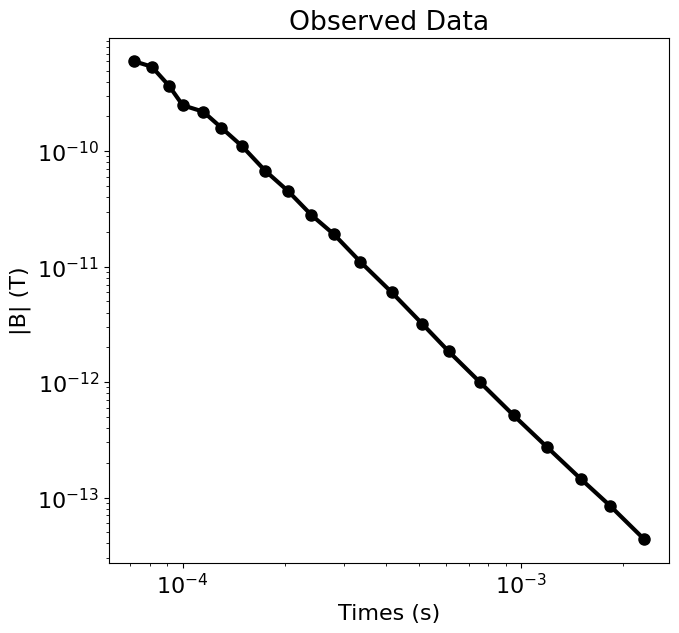

In [17]:
# Break down data into two variables: time and data
times = dobsIN[:, 0]
dobs = mkvc(dobsIN[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")

# Create Digital Equipment/Source model

In [18]:
# Source loop geometry
source_location = np.array([0.0, 0.0, 0.0])
source_orientation = "z"  # "x", "y" or "z"
source_current = 0.5  # peak current amplitude
source_radius = 10  # loop radius

# Receiver geometry
receiver_location = np.array([0.0, 0.0, 0.0])
receiver_orientation = "z"  # "x", "y" or "z"

# Receiver list
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Define the source waveform.
#https://docs.simpeg.xyz/latest/content/api/generated/simpeg.electromagnetics.time_domain.sources.StepOffWaveform.html#simpeg.electromagnetics.time_domain.sources.StepOffWaveform
waveform = tdem.sources.StepOffWaveform()

# Sources
#https://docs.simpeg.xyz/latest/content/api/generated/simpeg.electromagnetics.time_domain.sources.CircularLoop.html#simpeg.electromagnetics.time_domain.sources.CircularLoop
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Survey
survey = tdem.Survey(source_list)

In [19]:
# 5% of the absolute value
uncertainties = 0.25 * np.abs(dobs)

# Define the data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
uncertainties

array([1.5000e-10, 1.3500e-10, 9.2500e-11, 6.2500e-11, 5.5000e-11,
       4.0000e-11, 2.7500e-11, 1.7000e-11, 1.1250e-11, 7.0000e-12,
       4.7500e-12, 2.7500e-12, 1.4925e-12, 8.0000e-13, 4.6250e-13,
       2.5000e-13, 1.2875e-13, 6.8750e-14, 3.6250e-14, 2.1250e-14,
       1.1000e-14])

Text(0.5, 1.0, 'Observed Data')

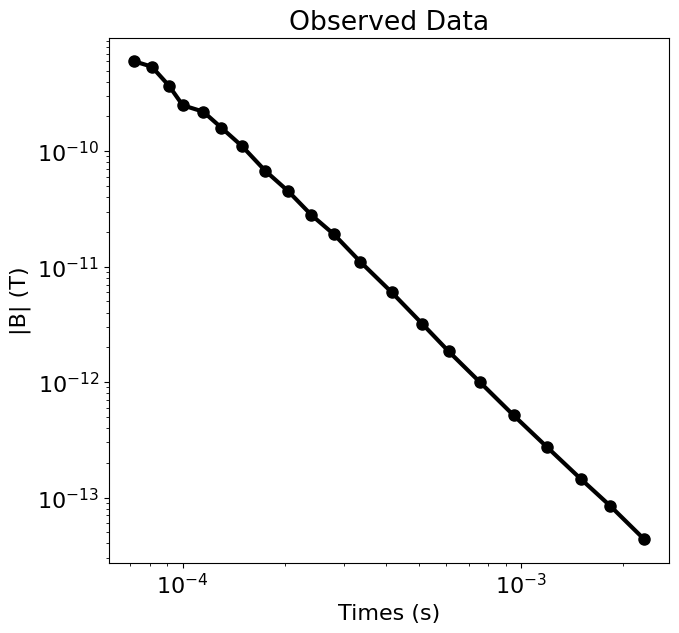

In [20]:
# Break down data into two variables: time and data
times = dobsIN[:, 0]
dobs = mkvc(dobsIN[:, -1])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")

# Create Inversion Mesh

In [45]:
# Layer thicknesses
inv_thicknesses = np.logspace(0, 1, 15)
print((np.r_[inv_thicknesses, inv_thicknesses[-1]]))
# Define a mesh for plotting and regularization.
#https://discretize.simpeg.xyz/en/latest/api/generated/discretize.TensorMesh.html
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
print(mesh)

[ 1.          1.17876863  1.38949549  1.63789371  1.93069773  2.27584593
  2.6826958   3.16227766  3.72759372  4.39397056  5.17947468  6.1054023
  7.19685673  8.48342898 10.         10.        ]

  TensorMesh: 16 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     16          0.00         70.34      1.00     10.00    1.18




# Define model

In [46]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(0.1 * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

# Create forward model (i.e., simulation)

In [47]:
#https://docs.simpeg.xyz/latest/content/api/generated/simpeg.electromagnetics.time_domain.Simulation1DLayered.html#simpeg.electromagnetics.time_domain.Simulation1DLayered
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

# Set up model parameters

In [48]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / uncertainties

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(mesh, mapping=reg_map, alpha_s=0.01, alpha_x=0.1)

# set reference model
reg.reference_model = starting_model

# Define sparse and blocky norms p, q
reg.norms = [1, 0]

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=20, maxIterLS=20, maxIterCG=30, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [49]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig()

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Directives for the IRLS
update_IRLS = directives.UpdateIRLS()

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

In [50]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

import warnings
import simpeg
warnings.filterwarnings('ignore', category=simpeg.utils.solver_utils.DefaultSolverWarning)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.67e+04  3.21e+03  0.00e+00  3.21e+03    5.37e+03      0              

c:\Users\balikian\LocalData\venvs\simpeg311\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)



   1  1.33e+04  9.93e+02  2.65e-02  1.35e+03    7.95e+02      0              
   2  6.67e+03  7.07e+02  4.41e-02  1.00e+03    5.49e+02      0   Skip BFGS  
   3  3.34e+03  4.80e+02  7.16e-02  7.19e+02    3.48e+02      0   Skip BFGS  
   4  1.67e+03  3.44e+02  1.05e-01  5.19e+02    2.10e+02      0   Skip BFGS  
   5  8.34e+02  2.64e+02  1.43e-01  3.84e+02    1.27e+02      0   Skip BFGS  
   6  4.17e+02  2.18e+02  1.90e-01  2.97e+02    7.51e+01      0   Skip BFGS  
   7  2.08e+02  1.83e+02  2.59e-01  2.38e+02    4.97e+01      0   Skip BFGS  
   8  1.04e+02  1.41e+02  4.25e-01  1.86e+02    7.44e+01      0   Skip BFGS  
   9  5.21e+01  1.21e+02  5.01e-01  1.47e+02    9.43e+01      2              
  10  2.61e+01  1.03e+02  6.30e-01  1.19e+02    1.56e+02      2   Skip BFGS  
  11  1.30e+01  9.88e+01  7.59e-01  1.09e+02    2.73e+02      2   Skip BFGS  
  12  6.52e+00  8.42e+01  8.91e-01  9.00e+01    3.33e+02      2   Skip BFGS  
  13  3.26e+00  7.26e+01  1.20e+00  7.65e+01    4.87e+02      1

(16,)


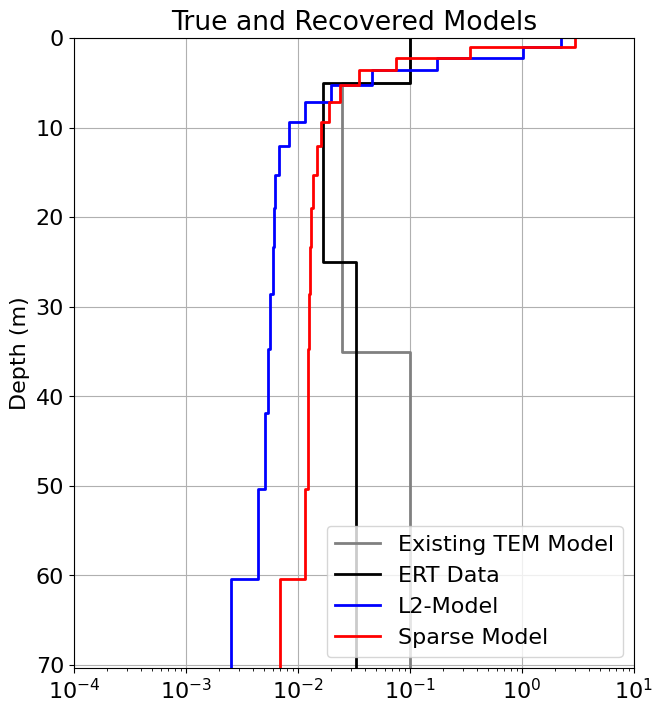

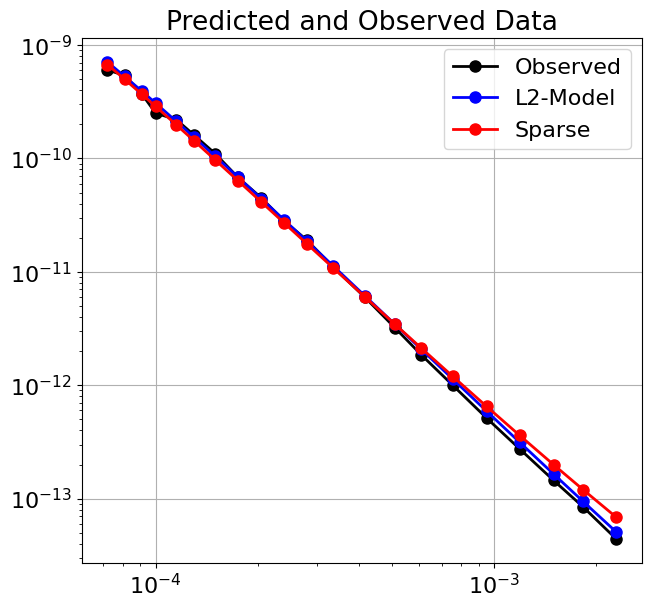

In [51]:
# Load the true model and layer thicknesses
true_model = np.array([0.1, 1.0, 0.1])
true_layers = np.r_[40.0, 40.0, 160.0]

true_layers = np.array([5, 30, 50, 150, 250])
true_model = np.r_[1/10, 1/40.0, 1/10,1/100, 1/5]

ert_layers = np.array([5,20,30])
ert_model = np.array([1/10, 1/60, 1/30])

# Extract Least-Squares model
l2_model = inv_prob.l2model
print(np.shape(l2_model))

# Plot true model and recovered model
fig = plt.figure(figsize=(8, 9))
x_min = np.min(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)
x_max = np.max(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_model, ax=ax1, show_layers=False, color="gray")
plot_1d_layer_model(ert_layers, ert_model, ax=ax1, show_layers=False, color="k")

# "Smooth (L2) model"
plot_1d_layer_model(
    mesh.h[0], model_mapping * l2_model, ax=ax1, show_layers=False, color="b"
)

# "Blocky" (L0/L1) model
plot_1d_layer_model(
    mesh.h[0], model_mapping * recovered_model, ax=ax1, show_layers=False, color="r"
)
ax1.set_xlim(0.0001, 10)
ax1.grid()
ax1.set_title("True and Recovered Models")
ax1.legend(["Existing TEM Model", "ERT Data", "L2-Model", "Sparse Model"])
#plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_l2 = simulation.dpred(l2_model)
dpred_final = simulation.dpred(recovered_model)

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred_l2), "b-o")
ax1.loglog(times, np.abs(dpred_final), "r-o")
ax1.grid()
#ax1.set_xlabel("times (Hz)")
#ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2-Model", "Sparse"], loc="upper right")
plt.show()